In [58]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from obspy.signal.invsim import cosine_taper #used to smooth data at ends
from obspy.signal.filter import highpass #filter to remove low frequency noise from seismic data
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset#used to see when ratio is triggered
from scipy.fft import fft, fftfreq

In [59]:
def load_mseed(file_path):
    st = read(file_path)
    tr = st.traces[0].copy()
    return tr

def get_arrival(tr, time):
  tr_times = tr.times()
  tr_data = tr.data
  starttime = tr.stats.starttime.datetime
  return (time - starttime).total_seconds()

def apply_bandpass_filter(st, min_freq, max_freq):
    st_filt = st.copy()
    st_filt.filter('bandpass', freqmin=min_freq, freqmax=max_freq)
    return st_filt

def compute_sta_lta(trace, sta_len, lta_len):
    sampling_rate = trace.stats.sampling_rate
    cft = classic_sta_lta(trace.data, int(sta_len * sampling_rate), int(lta_len * sampling_rate))
    return cft

def detect_seismic_events(trace, sta_len, lta_len, thr_on=4.0, thr_off=1.5):
    cft = compute_sta_lta(trace, sta_len, lta_len)
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    return on_off
def detrend_trace(trace):
    return trace.detrend('linear')
def extract_sta_lta_features(trace, sta_len, lta_len):

    cft = compute_sta_lta(trace, sta_len, lta_len)


    max_sta_lta = np.max(cft)
    mean_sta_lta = np.mean(cft)
    var_sta_lta = np.var(cft)

    return max_sta_lta, mean_sta_lta, var_sta_lta

def extract_time_domain_features(trace):

    data = trace.data

    mean_amp = np.mean(data)
    max_amp = np.max(data)
    rms_amp = np.sqrt(np.mean(data**2))

    return mean_amp, max_amp, rms_amp

def extract_event_duration(trace, sta_len, lta_len, thr_on=4.0, thr_off=1.5):

    cft = compute_sta_lta(trace, sta_len, lta_len)
    on_off = trigger_onset(cft, thr_on, thr_off)

    if len(on_off) > 0:
        # Calculate the durations of each detected event
        event_durations = [(end - start) / trace.stats.sampling_rate for start, end in on_off]
        return np.mean(event_durations) if event_durations else 0
    return 0


def extract_frequency_domain_features(trace):
    """
    Extracts frequency-based features from the entire trace using Fourier Transform.
    """
    data = trace.data
    n = len(data)
    sampling_rate = trace.stats.sampling_rate

    # Compute Fourier transform
    fft_values = np.abs(fft(data))  # Absolute values of FFT
    freqs = fftfreq(n, 1 / sampling_rate)  # Frequencies

    # Only consider positive frequencies
    fft_values = fft_values[:n // 2]
    freqs = freqs[:n // 2]

    # Dominant frequency: frequency with the highest energy
    dom_freq = freqs[np.argmax(fft_values)]

    # Mean frequency (weighted by energy)
    mean_freq = np.sum(freqs * fft_values) / np.sum(fft_values)

    # Bandwidth: range of frequencies with significant energy
    bandwidth = freqs[np.argmax(fft_values)] - freqs[np.argmin(fft_values)]

    return dom_freq, mean_freq, bandwidtha

In [92]:
import numpy as np
from obspy.signal.trigger import classic_sta_lta, trigger_onset

# Modified function to compute STA/LTA and return max_sta_lta value with its time
def compute_sta_lta_with_time(trace, sta_len, lta_len):
    sampling_rate = trace.stats.sampling_rate
    cft = classic_sta_lta(trace.data, int(sta_len * sampling_rate), int(lta_len * sampling_rate))
    
    max_sta_lta = np.max(cft)
    max_sta_lta_idx = np.argmax(cft)
    
    # Calculate the time when max_sta_lta occurred
    max_sta_lta_time = trace.stats.starttime + (max_sta_lta_idx / sampling_rate)
    
    return cft, max_sta_lta, max_sta_lta_time

# Function to detect the first STA/LTA event (start and end times)
def detect_sta_lta_events(trace, sta_len, lta_len):
    thr_on=2.0
    thr_off=1.0
    cft, _, _ = compute_sta_lta_with_time(trace, sta_len, lta_len)
    on_off = trigger_onset(cft, thr_on, thr_off)

    if len(on_off) > 0:
        start_idx, end_idx = on_off[0]  # First STA/LTA event
        start_time = trace.stats.starttime + (start_idx / trace.stats.sampling_rate)
        end_time = trace.stats.starttime + (end_idx / trace.stats.sampling_rate)
        return start_time, end_time
    return None, None

# Function to extract STA/LTA features and timings
def extract_sta_lta_features_with_time(trace, sta_len, lta_len):
    cft, max_sta_lta, max_sta_lta_time = compute_sta_lta_with_time(trace, sta_len, lta_len)
    mean_sta_lta = np.mean(cft)
    var_sta_lta = np.var(cft)

    return max_sta_lta, max_sta_lta_time, mean_sta_lta, var_sta_lta

# Modified function to extract amplitude features, including min amplitude and its time
def extract_time_domain_features_with_max_min_time(trace):
    data = trace.data
    sampling_rate = trace.stats.sampling_rate

    # Extract mean, max, min, and RMS amplitude
    mean_amp = np.mean(data)
    max_amp = np.max(data)
    max_amp_idx = np.argmax(data)

    min_amp = np.min(data)
    min_amp_idx = np.argmin(data)

    # Calculate the times when max_amp and min_amp occurred
    max_amp_time = trace.stats.starttime + (max_amp_idx / sampling_rate)
    min_amp_time = trace.stats.starttime + (min_amp_idx / sampling_rate)

    rms_amp = np.sqrt(np.mean(data**2))

    return mean_amp, max_amp, max_amp_time, min_amp, min_amp_time, rms_amp


# Function to extract event duration features
def extract_event_duration(trace, sta_len, lta_len):
    thr_on=4.0
    thr_off=1.5
    cft = compute_sta_lta_with_time(trace, sta_len, lta_len)[0]
    on_off = trigger_onset(cft, thr_on, thr_off)

    if len(on_off) > 0:
        # Calculate the durations of each detected event
        event_durations = [(end - start) / trace.stats.sampling_rate for start, end in on_off]
        return np.mean(event_durations) if event_durations else 0
    return 0


In [93]:
import pandas as pd
from datetime import datetime
cat_file_path = r'C:\Users\akshi\Machine Learning Projects\Space Apps Challenge\data\lunar\training\catalogs\apollo12_catalog_GradeA_final.csv' #change this to the specific catalog file

cat = pd.read_csv(cat_file_path)
cat
# DataFrame to hold features for each file
features_list = []

# Loop through each row in 'cat' DataFrame
for i in range(0, cat.shape[0]):
    row = cat.iloc[i]
    try:
        # Convert time
        time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
        rel_time = row['time_rel(sec)']
        filename = row['filename']

        # File path to the .mseed file
        data_directory = r'C:\Users\akshi\Machine Learning Projects\Space Apps Challenge\data\lunar\training\data\S12_GradeA' 
        mseed_file = f'{data_directory}\{filename}.mseed'

        # Load and process the mseed file
        if load_mseed(mseed_file):
            tr = load_mseed(mseed_file)

            # Get the arrival time and apply bandpass filter
            arrival = get_arrival(tr, time)
            tr_filt = apply_bandpass_filter(tr, 0.5, 1.0)

            # Feature extraction
            max_sta_lta, max_sta_lta_time, mean_sta_lta, var_sta_lta = extract_sta_lta_features_with_time(tr_filt, sta_len=200, lta_len=475)
            
            # Extract amplitude-related features
            mean_amp, max_amp, max_amp_time, min_amp, min_amp_time, rms_amp = extract_time_domain_features_with_max_min_time(tr_filt)

            event_duration = extract_event_duration(tr_filt, sta_len=200, lta_len=475)

            # Detect the first STA/LTA event (threshold 4.0)
            sta_lta_start_time, sta_lta_end_time = detect_sta_lta_events(tr_filt, sta_len=200, lta_len=475)

            # Append extracted features to the features list
            features_list.append({
                'filename': filename,
                'arrival': arrival,
                'max_sta_lta': max_sta_lta,
                'max_sta_lta_time': (max_sta_lta_time - tr.stats.starttime),  # Time of max STA/LTA
                'mean_sta_lta': mean_sta_lta,
                'var_sta_lta': var_sta_lta,
                'max_amp': max_amp,
                'max_amp_time': (max_amp_time - tr.stats.starttime),  # Time of max amplitude
                'min_amp': min_amp,
                'min_amp_time': (min_amp_time - tr.stats.starttime),  # Time of min amplitude
                'mean_amp': mean_amp,
                'rms_amp': rms_amp,
                'event_duration': event_duration,
                'sta_lta_start_time': (sta_lta_start_time - tr.stats.starttime) if sta_lta_start_time else None,  # First STA/LTA start time
                'sta_lta_end_time': (sta_lta_end_time - tr.stats.starttime) if sta_lta_end_time else None  # First STA/LTA end time
            })


    except FileNotFoundError:
        print(f"File not found: {mseed_file}. Skipping to the next file.")
    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")

# Convert the list of features into a DataFrame
features_df = pd.DataFrame(features_list)

# Show the DataFrame
features_df.head()


,filename,arrival,max_sta_lta,max_sta_lta_time,mean_sta_lta,var_sta_lta,max_amp,max_amp_time,min_amp,min_amp_time,mean_amp,rms_amp,event_duration,sta_lta_start_time,sta_lta_end_time
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,73499.335,2.374340,37625.811321,1.015039,0.326191,7.168520e-09,73991.547170,-7.097313e-09,73990.943396,2.723003e-20,3.000852e-10,0.0,474.716981,882.867925
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,12719.560,2.295762,16873.962264,0.995377,0.039389,4.337924e-09,13448.905660,-4.348940e-09,13449.509434,2.426280e-21,2.318099e-10,0.0,474.716981,1021.283019
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,73019.435,2.374340,24264.150943,0.998502,0.096869,5.446156e-09,73572.377358,-5.906712e-09,73571.773585,1.216101e-20,2.508909e-10,0.0,474.716981,1388.226415
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,4439.804,2.310864,474.867925,0.994062,0.077505,6.482011e-09,5300.679245,-6.443661e-09,5301.283019,-4.978128e-21,2.935849e-10,0.0,474.716981,1627.018868
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,52139.340,2.296394,474.716981,0.993744,0.050529,3.570016e-09,52970.113208,-3.922370e-09,52514.264151,-3.539701e-22,2.289006e-10,0.0,474.716981,1026.264151


In [94]:
features_df

,filename,arrival,max_sta_lta,max_sta_lta_time,mean_sta_lta,var_sta_lta,max_amp,max_amp_time,min_amp,min_amp_time,mean_amp,rms_amp,event_duration,sta_lta_start_time,sta_lta_end_time
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,73499.335,2.374340,37625.811321,1.015039,0.326191,7.168520e-09,73991.547170,-7.097313e-09,73990.943396,2.723003e-20,3.000852e-10,0.0,474.716981,882.867925
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,12719.560,2.295762,16873.962264,0.995377,0.039389,4.337924e-09,13448.905660,-4.348940e-09,13449.509434,2.426280e-21,2.318099e-10,0.0,474.716981,1021.283019
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,73019.435,2.374340,24264.150943,0.998502,0.096869,5.446156e-09,73572.377358,-5.906712e-09,73571.773585,1.216101e-20,2.508909e-10,0.0,474.716981,1388.226415
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,4439.804,2.310864,474.867925,0.994062,0.077505,6.482011e-09,5300.679245,-6.443661e-09,5301.283019,-4.978128e-21,2.935849e-10,0.0,474.716981,1627.018868
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,52139.340,2.296394,474.716981,0.993744,0.050529,3.570016e-09,52970.113208,-3.922370e-09,52514.264151,-3.539701e-22,2.289006e-10,0.0,474.716981,1026.264151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,xa.s12.00.mhz.1974-10-14HR00_evid00156,63779.004,2.374246,1219.773585,1.001939,0.458038,5.891982e-09,64182.943396,-6.044107e-09,64491.471698,1.885967e-23,2.325307e-10,0.0,474.716981,818.867925
71,xa.s12.00.mhz.1975-04-12HR00_evid00191,65699.813,2.363714,696.754717,0.998241,0.258681,5.288960e-08,66322.566038,-4.998219e-08,66220.377358,-1.125688e-20,1.837439e-09,0.0,537.509434,944.603774
72,xa.s12.00.mhz.1975-05-04HR00_evid00192,36299.543,2.369645,36504.754717,0.989006,0.034921,1.034582e-07,37448.301887,-1.041873e-07,37447.698113,3.310777e-23,3.437509e-09,0.0,474.716981,1996.679245
73,xa.s12.00.mhz.1975-06-24HR00_evid00196,57779.761,2.373947,723.924528,0.998972,0.174482,6.624310e-09,57892.226415,-6.706438e-09,57891.773585,-6.691174e-21,1.961781e-10,0.0,474.716981,940.075472


In [95]:
features_df.dropna()

,filename,arrival,max_sta_lta,max_sta_lta_time,mean_sta_lta,var_sta_lta,max_amp,max_amp_time,min_amp,min_amp_time,mean_amp,rms_amp,event_duration,sta_lta_start_time,sta_lta_end_time
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,73499.335,2.374340,37625.811321,1.015039,0.326191,7.168520e-09,73991.547170,-7.097313e-09,73990.943396,2.723003e-20,3.000852e-10,0.0,474.716981,882.867925
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,12719.560,2.295762,16873.962264,0.995377,0.039389,4.337924e-09,13448.905660,-4.348940e-09,13449.509434,2.426280e-21,2.318099e-10,0.0,474.716981,1021.283019
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,73019.435,2.374340,24264.150943,0.998502,0.096869,5.446156e-09,73572.377358,-5.906712e-09,73571.773585,1.216101e-20,2.508909e-10,0.0,474.716981,1388.226415
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,4439.804,2.310864,474.867925,0.994062,0.077505,6.482011e-09,5300.679245,-6.443661e-09,5301.283019,-4.978128e-21,2.935849e-10,0.0,474.716981,1627.018868
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,52139.340,2.296394,474.716981,0.993744,0.050529,3.570016e-09,52970.113208,-3.922370e-09,52514.264151,-3.539701e-22,2.289006e-10,0.0,474.716981,1026.264151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,xa.s12.00.mhz.1974-10-14HR00_evid00156,63779.004,2.374246,1219.773585,1.001939,0.458038,5.891982e-09,64182.943396,-6.044107e-09,64491.471698,1.885967e-23,2.325307e-10,0.0,474.716981,818.867925
71,xa.s12.00.mhz.1975-04-12HR00_evid00191,65699.813,2.363714,696.754717,0.998241,0.258681,5.288960e-08,66322.566038,-4.998219e-08,66220.377358,-1.125688e-20,1.837439e-09,0.0,537.509434,944.603774
72,xa.s12.00.mhz.1975-05-04HR00_evid00192,36299.543,2.369645,36504.754717,0.989006,0.034921,1.034582e-07,37448.301887,-1.041873e-07,37447.698113,3.310777e-23,3.437509e-09,0.0,474.716981,1996.679245
73,xa.s12.00.mhz.1975-06-24HR00_evid00196,57779.761,2.373947,723.924528,0.998972,0.174482,6.624310e-09,57892.226415,-6.706438e-09,57891.773585,-6.691174e-21,1.961781e-10,0.0,474.716981,940.075472


In [97]:
features_df.to_csv('Features_New_Expanded.csv', index=False) #change this to the specific file name you want to save the features to

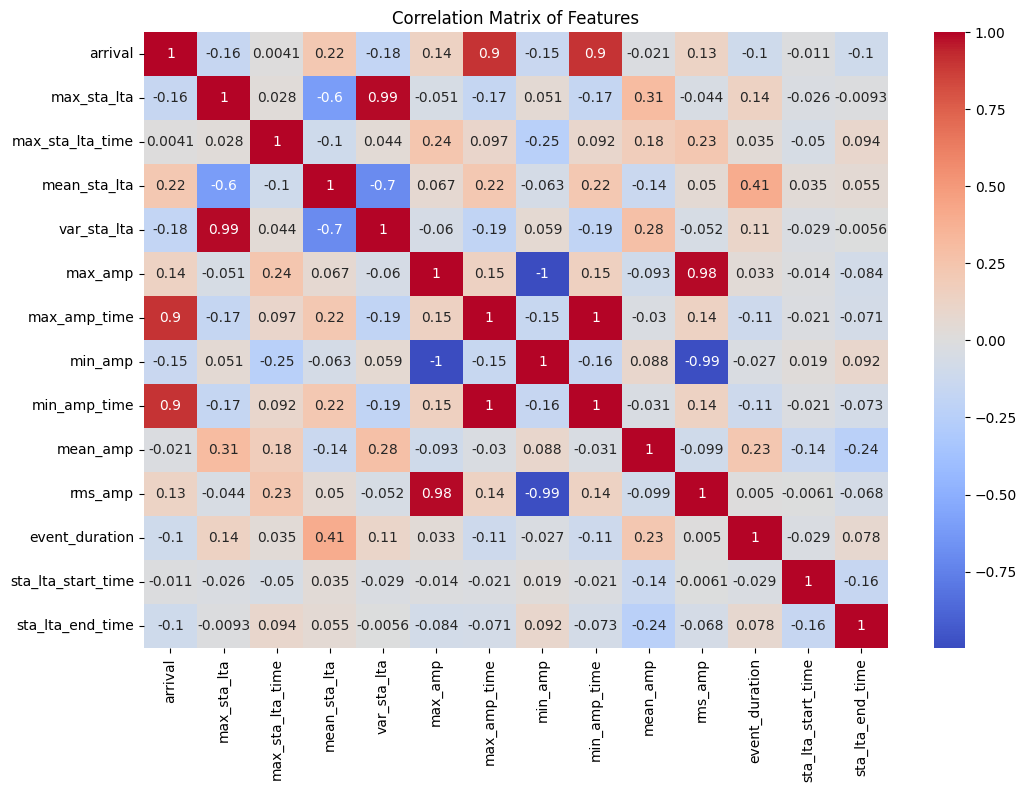

In [96]:
corr_df =  features_df.drop(columns=['filename']).corr()
corr_df
# plot this out
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


In [56]:
import numpy as np

# Function to compute STA/LTA for correlation analysis
def compute_sta_lta_for_correlation(trace, sta_len, lta_len):
    sampling_rate = trace.stats.sampling_rate
    cft = classic_sta_lta(trace.data, int(sta_len * sampling_rate), int(lta_len * sampling_rate))
    return cft

# Defining the range for sta and lta lengths
sta_min, sta_max = 150, 201  # Example range
lta_min, lta_max = 475, 526  # Example range
increment = 5  # Increase by 5 each iteration

# Store results
best_sta_lta_combinations = []

# Nested loop for STA/LTA combinations
for sta_len in range(sta_min, sta_max + 1, increment):
    for lta_len in range(lta_min, lta_max + 1, increment):
        # List to store STA/LTA results for each file
        sta_lta_results = []
        
        # Loop through each file and compute STA/LTA features
        for i in range(0, cat.shape[0]):
            row = cat.iloc[i]
            try:
                # Convert time
                time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
                filename = row['filename']

                # File path to the .mseed file
                data_directory = 'C:\\Users\\akshi\\Machine Learning Projects\\Space Apps Challenge\\data\\lunar\\training\\data\\S12_GradeA'
                mseed_file = f'{data_directory}\\{filename}.mseed'

                # Load and process the mseed file
                if load_mseed(mseed_file):
                    tr = load_mseed(mseed_file)

                    # Get the arrival time
                    arrival = get_arrival(tr, time)
                    
                    # Apply STA/LTA calculation for the current sta_len and lta_len
                    cft = compute_sta_lta_for_correlation(tr, sta_len, lta_len)

                    # Append the result and the corresponding arrival time
                    sta_lta_results.append({
                        'arrival': arrival,
                        'sta_lta_mean': np.mean(cft)  # Using the mean of the STA/LTA values
                    })
                    
            except FileNotFoundError:
                print(f"File not found: {mseed_file}. Skipping to the next file.")
            except Exception as e:
                print(f"An error occurred while processing {filename}: {e}")

        # Convert the STA/LTA results into a DataFrame
        if len(sta_lta_results) > 0:
            sta_lta_df = pd.DataFrame(sta_lta_results)

            # Check if there are valid STA/LTA results to compute correlation
            if 'arrival' in sta_lta_df.columns and 'sta_lta_mean' in sta_lta_df.columns:
                # Calculate the correlation between arrival times and the STA/LTA features
                correlation = sta_lta_df['arrival'].corr(sta_lta_df['sta_lta_mean'])
                
                # If the correlation is greater than 0.2, print the values of sta_len and lta_len
                if correlation > 0.2:
                    print(f"STA: {sta_len}, LTA: {lta_len}, Correlation: {correlation:.3f}")
                    best_sta_lta_combinations.append((sta_len, lta_len, correlation))

# Optionally store best combinations in a DataFrame or display
if len(best_sta_lta_combinations) > 0:
    best_combinations_df = pd.DataFrame(best_sta_lta_combinations, columns=['STA Length', 'LTA Length', 'Correlation'])

    print(best_combinations_df)


STA: 150, LTA: 485, Correlation: 0.202
STA: 155, LTA: 480, Correlation: 0.207
STA: 155, LTA: 485, Correlation: 0.213
STA: 155, LTA: 495, Correlation: 0.206
STA: 160, LTA: 505, Correlation: 0.210
STA: 160, LTA: 515, Correlation: 0.201
STA: 170, LTA: 485, Correlation: 0.208
STA: 175, LTA: 495, Correlation: 0.204
STA: 180, LTA: 480, Correlation: 0.214
STA: 180, LTA: 495, Correlation: 0.211
STA: 180, LTA: 510, Correlation: 0.219
STA: 185, LTA: 485, Correlation: 0.204
STA: 190, LTA: 520, Correlation: 0.216
STA: 195, LTA: 485, Correlation: 0.216
STA: 200, LTA: 475, Correlation: 0.230
STA: 200, LTA: 480, Correlation: 0.226
STA: 200, LTA: 495, Correlation: 0.226
STA: 200, LTA: 510, Correlation: 0.214
    STA Length  LTA Length  Correlation
0          150         485     0.202305
1          155         480     0.206937
2          155         485     0.212623
3          155         495     0.205737
4          160         505     0.209640
5          160         515     0.200598
6          170    

In [57]:
best_combinations_df

,STA Length,LTA Length,Correlation
0,150,485,0.202305
1,155,480,0.206937
2,155,485,0.212623
3,155,495,0.205737
4,160,505,0.209640
5,160,515,0.200598
6,170,485,0.207657
7,175,495,0.204082
8,180,480,0.214079
9,180,495,0.210875


In [55]:
best_combinations_df

,STA Length,LTA Length,Correlation
0,155,485,0.212623
1,180,510,0.219117
